In [1]:
from keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K
from keras.utils.image_utils import img_to_array, array_to_img, load_img
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Recall, Precision
from metrics import dice_loss, dice_coef, iou
import os
import cv2
import glob
import numpy as np
from PIL import Image, ImageOps
from skimage import color
from skimage import io
img = []
masks = []
IMAGE_SIZE = 512

In [2]:
def training_data():
    
    img_dir = './newimg' #orginal directory
    mask_dir = './newMasks' #augmented directory
    data_img_path = os.path.join(img_dir,'*g')
    data_mask_path = os.path.join(mask_dir,'*g')

    img_files = glob.glob(data_img_path) #error @ rgb_img when removing glob.glob dunno y
    mask_files = glob.glob(data_mask_path)
    
    for f1 in img_files:
        orgImg = Image.open(f1).resize((IMAGE_SIZE, IMAGE_SIZE))
        mirImg = ImageOps.mirror(Image.open(f1).resize((IMAGE_SIZE, IMAGE_SIZE)))
        
        
        img.append(np.array(orgImg)) 
        img.append(np.array(mirImg))
        img.append(np.array(ImageOps.flip(orgImg)))
        img.append(np.array(ImageOps.flip(mirImg)))
        
    for f2 in mask_files:
        
        orgMask = Image.open(f2).resize((IMAGE_SIZE, IMAGE_SIZE))
        mirMask = ImageOps.mirror(Image.open(f2).resize((IMAGE_SIZE, IMAGE_SIZE)))
        
        masks.append(np.array(orgMask))
        masks.append(np.array(mirMask))
        masks.append(np.array(ImageOps.flip(orgMask)))
        masks.append(np.array(ImageOps.flip(mirMask)))
        
  
training_data()

In [3]:
img_np = np.array(img)
masks_np = np.array(masks)

In [4]:
print(img_np.shape, masks_np.shape)

(400, 512, 512) (400, 512, 512, 4)


In [5]:
#masks_np = np.array(masks_np/255.0)
masksCV = []
imgCV = []

for f2 in masks_np:
   masksCV.append(cv2.cvtColor(f2, cv2.COLOR_BGR2GRAY))
    

#for f2 in img:
#    imgCV.append(Image.open(f2))

masksCV_np = np.array(masksCV)



In [6]:
print(img_np.shape, masksCV_np.shape)

(400, 512, 512) (400, 512, 512)


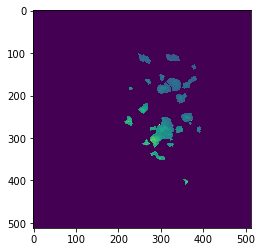

In [7]:
from matplotlib import pyplot as plt
plt.imshow(masksCV_np[0], interpolation='nearest')
plt.show()

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


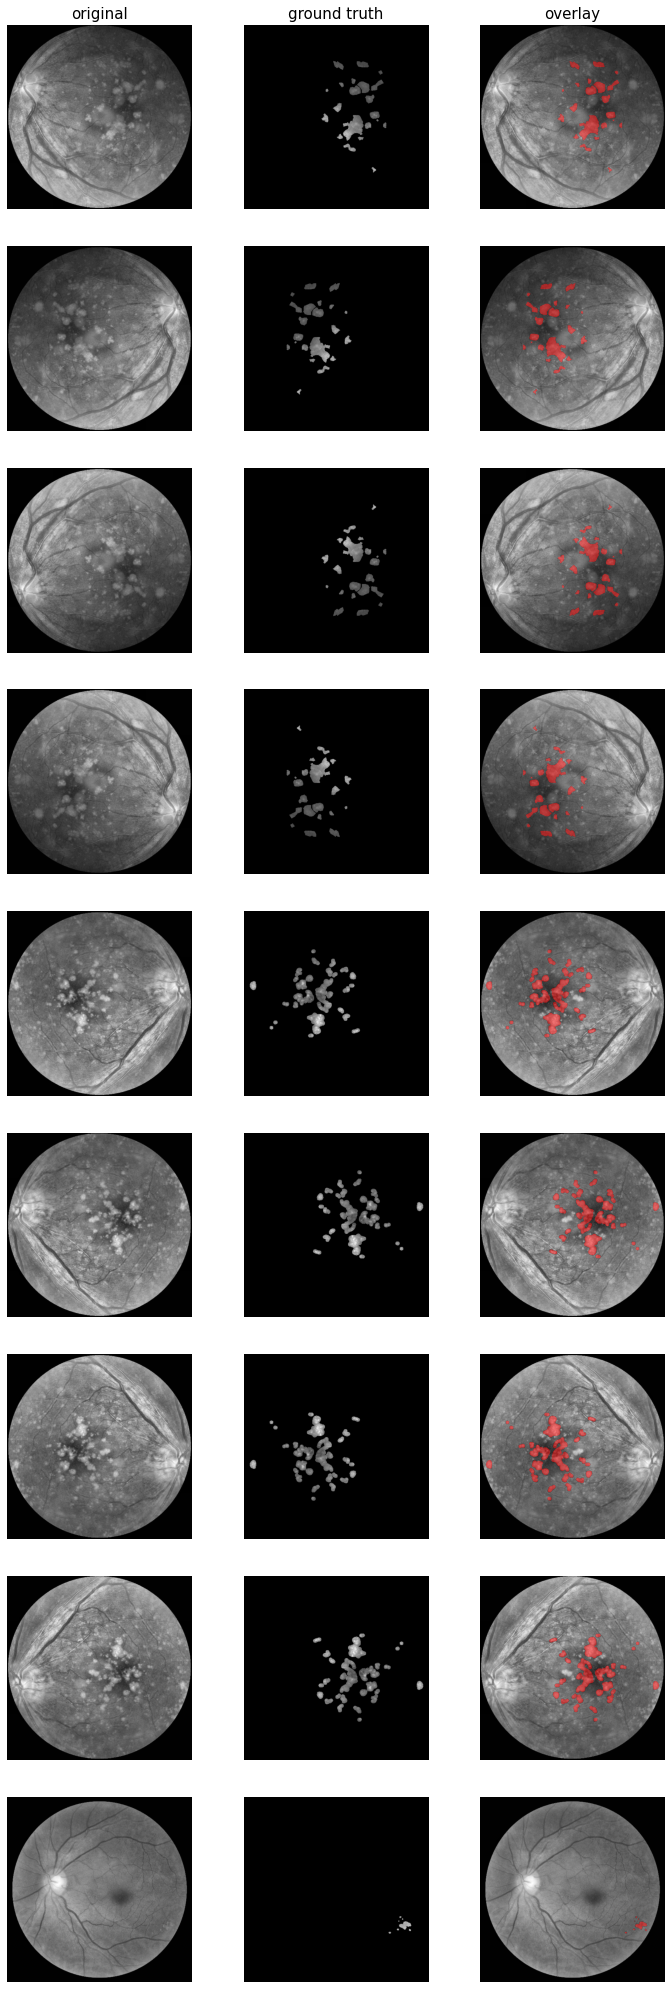

In [8]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=img_np, mask_imgs=masksCV_np, nm_img_to_plot=9, figsize=4)

In [9]:
print(img_np.max(), masksCV_np.max())

255 255


In [10]:
x = np.asarray(img_np, dtype=np.float32)/255
y = np.asarray(masksCV_np, dtype=np.float32)/255

In [11]:
print(x.max(), y.max())

1.0 1.0


In [12]:
print(x.shape, y.shape)

(400, 512, 512) (400, 512, 512)


In [13]:
x = np.expand_dims(x, axis = 1)
y = np.expand_dims(y, axis =1)

In [14]:
#checks if image input is b&w
##if(x[0][0][0].shape == ()):
##  x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)

##y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)
    
print(x.shape, y.shape)

(400, 1, 512, 512) (400, 1, 512, 512)


In [15]:
from sklearn.model_selection import train_test_split

x_train, x_rem, y_train, y_rem = train_test_split(x, y, test_size=0.1, random_state=1)

x_val, x_test, y_val, y_test = train_test_split(x_rem, y_rem, test_size=0.5, random_state=1)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_rem: ", x_rem.shape)
print("y_rem: ", y_rem.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)


x_train:  (360, 1, 512, 512)
y_train:  (360, 1, 512, 512)
x_rem:  (40, 1, 512, 512)
y_rem:  (40, 1, 512, 512)
x_val:  (20, 1, 512, 512)
y_val:  (20, 1, 512, 512)


In [16]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("this happened")

## MSU Net Implementation


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import onnx
from onnx_tf.backend import prepare
import tensorflow as tf

from MSUnet_Model import MSU_Net

c:\Users\mackr\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [18]:
#torch.cuda.is_available = lambda : False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
model_pytorch = MSU_Net(1,1)

In [20]:
train_loader = DataLoader(dataset=(x_train, y_train), batch_size=8, shuffle=True)
test_loader = DataLoader(dataset=(x_test, y_test), batch_size=8, shuffle=False)

In [21]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1050 Ti'

In [22]:
import time

In [23]:
from torchsummary import summary
summary(model_pytorch.to(device), (1,IMAGE_SIZE, IMAGE_SIZE))

torch.Size([2, 1, 512, 512])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 512, 512]              80
       BatchNorm2d-2          [-1, 8, 512, 512]              16
              ReLU-3          [-1, 8, 512, 512]               0
            Conv2d-4          [-1, 8, 512, 512]             584
       BatchNorm2d-5          [-1, 8, 512, 512]              16
              ReLU-6          [-1, 8, 512, 512]               0
      conv_block_3-7          [-1, 8, 512, 512]               0
            Conv2d-8          [-1, 8, 512, 512]             400
       BatchNorm2d-9          [-1, 8, 512, 512]              16
             ReLU-10          [-1, 8, 512, 512]               0
           Conv2d-11          [-1, 8, 512, 512]           3,144
      BatchNorm2d-12          [-1, 8, 512, 512]              16
             ReLU-13          [-1, 8, 512, 512]               0
     conv_

In [28]:
print(torch.__version__)

2.0.0+cu117


In [24]:
def trainTestModel(model):
    num_epochs = 20
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Train model
    time_start = time.time()

    for epoch in range(num_epochs):
        model.train()
        
        train_loss_total = 0
        
        for data, target in train_loader:
            data, target = data.to(device), target.float().to(device)
            optimizer.zero_grad()
            output = model(data)
            train_loss = criterion(output, target)
            train_loss.backward()
            optimizer.step()
            train_loss_total += train_loss.item() * data.size(0)
            
        print('Epoch {} completed. Train loss is {:.3f}'.format(epoch + 1, train_loss_total / x_train.shape[0]))
    print('Time taken to completed {} epochs: {:.2f} minutes'.format(num_epochs, (time.time() - time_start) / 60))

    # Evaluate model
    model.eval()

    test_loss_total = 0
    total_num_corrects = 0
    threshold = 0.5
    time_start = time.time()

    for data, target in test_loader:
        data, target = data.to(device), target.float().to(device)
        optimizer.zero_grad()
        output = model(data)
        train_loss = criterion(output, target)
        train_loss.backward()
        optimizer.step()
        train_loss_total += train_loss.item() * data.size(0)
        
        pred = (output >= threshold).view_as(target)  # to make pred have same shape as target
        num_correct = torch.sum(pred == target.byte()).item()
        total_num_corrects += num_correct

    print('Evaluation completed. Test loss is {:.3f}'.format(test_loss_total / y_test.shape[0]))
    print('Test accuracy is {:.3f}'.format(total_num_corrects / y_test.shape[0]))
    print('Time taken to complete evaluation: {:.2f} minutes'.format((time.time() - time_start) / 60))

In [25]:
torch.save(model_pytorch.state_dict(), './model_MSUnet.pt')

In [26]:
#model_pytorch.load_state_dict(torch.load('./model_MSUnet.pt'))

In [27]:
dummy_input = torch.from_numpy(x_val).float().to(device)
dummy_output = model_pytorch(dummy_input)
print(dummy_output)


OutOfMemoryError: CUDA out of memory. Tried to allocate 10.00 MiB (GPU 0; 4.00 GiB total capacity; 3.49 GiB already allocated; 0 bytes free; 3.51 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF